In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
with open('sherlock_holmes.txt', 'r') as f:
    text = f.read().lower()

In [6]:

text[:1000]

'\ufeffthe project gutenberg ebook of the adventures of sherlock holmes,\nby arthur conan doyle\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww.gutenberg.org. if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook.\n\ntitle: the adventures of sherlock holmes\n\nauthor: arthur conan doyle\n\nrelease date: november 29, 2002 [ebook #1661]\n[most recently updated: october 10, 2023]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\nproduced by: an anonymous project gutenberg volunteer and jose menendez\n\n*** start of the project gutenberg ebook the adventures of sherlock\nholmes ***\n\n\n\n\nthe adventures of sherlock holmes\n\nby arthur conan doyle\n\n\nc

In [7]:
tilde_count = text.count('~')
print(tilde_count)

0


In [8]:
import re
text = re.sub(r'\n+', '~', text)
text = re.sub(r'\n', ' ', text)
print(text[:1000])

# Remove unwanted characters while retaining '.', and extra spaces
processed_text = re.sub('[^a-zA-Z0-9 \.~]', '', text)  # Remove unwanted characters except for . and ~
processed_text = re.sub(r'\.', ' . ', processed_text)  # add spaces
processed_text = re.sub(r'\s+', ' ', processed_text)  # Replace multiple spaces with a single space
processed_text = re.sub(r'~', '\n', processed_text)  # Replace multiple spaces with a single space

# Final cleanup to remove leading/trailing spaces
processed_text = processed_text.strip()


print(processed_text[:1000])

﻿the project gutenberg ebook of the adventures of sherlock holmes,~by arthur conan doyle~this ebook is for the use of anyone anywhere in the united states and~most other parts of the world at no cost and with almost no restrictions~whatsoever. you may copy it, give it away or re-use it under the terms~of the project gutenberg license included with this ebook or online at~www.gutenberg.org. if you are not located in the united states, you~will have to check the laws of the country where you are located before~using this ebook.~title: the adventures of sherlock holmes~author: arthur conan doyle~release date: november 29, 2002 [ebook #1661]~[most recently updated: october 10, 2023]~language: english~character set encoding: utf-8~produced by: an anonymous project gutenberg volunteer and jose menendez~*** start of the project gutenberg ebook the adventures of sherlock~holmes ***~the adventures of sherlock holmes~by arthur conan doyle~contents~   i.     a scandal in bohemia~   ii.    the red

In [9]:
len(processed_text)

570105

In [10]:
words = processed_text.split()
unique_words = sorted(list(set(words)))
print(unique_words[5000:5100])
stoi = {word: i for i, word in enumerate(unique_words)}
itos = {i: word for word, i in stoi.items()}

print(stoi)
print(itos)
print(len(stoi))
print(len(itos))

['mud', 'mudbank', 'mudstains', 'muff', 'multiply', 'mumbled', 'mumbling', 'munich', 'munificent', 'munro', 'murder', 'murdered', 'murderer', 'murderers', 'murdering', 'murderous', 'murders', 'murdertrap', 'murky', 'murmured', 'muscles', 'museum', 'museumwe', 'music', 'musician', 'must', 'mustard', 'muster', 'muttered', 'muttering', 'muzzle', 'my', 'myself', 'mysteries', 'mysterious', 'mystery', 'myth', 'nail', 'nails', 'naked', 'name', 'named', 'names', 'napoleons', 'narrated', 'narrative', 'narratives', 'narrow', 'narrowed', 'narrowly', 'nation', 'national', 'native', 'nativeborn', 'natural', 'naturally', 'nature', 'nautical', 'nay', 'ne', 'near', 'nearer', 'nearest', 'nearing', 'nearly', 'neat', 'neatly', 'neatness', 'necessarily', 'necessary', 'necessitate', 'necessity', 'neck', 'necktie', 'ned', 'need', 'needed', 'needlework', 'needs', 'negligence', 'negro', 'negroes', 'neighbour', 'neighbourhood', 'neighbouring', 'neighbours', 'neither', 'nerve', 'nerves', 'nervous', 'nervously',

In [11]:
processed_text[:1000]

'the project gutenberg ebook of the adventures of sherlock holmes\nby arthur conan doyle\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever . you may copy it give it away or reuse it under the terms\nof the project gutenberg license included with this ebook or online at\nwww . gutenberg . org . if you are not located in the united states you\nwill have to check the laws of the country where you are located before\nusing this ebook . \ntitle the adventures of sherlock holmes\nauthor arthur conan doyle\nrelease date november 29 2002 ebook 1661\nmost recently updated october 10 2023\nlanguage english\ncharacter set encoding utf8\nproduced by an anonymous project gutenberg volunteer and jose menendez\n start of the project gutenberg ebook the adventures of sherlock\nholmes \nthe adventures of sherlock holmes\nby arthur conan doyle\ncontents\n i . a scandal in bohemia\n ii . the redhead

In [12]:
paragraph_text = processed_text.split('\n')
paragraph_text = [s.strip() for s in paragraph_text]

for i, s in enumerate(paragraph_text[:10]):
  print(f"{i}: {s}")

0: the project gutenberg ebook of the adventures of sherlock holmes
1: by arthur conan doyle
2: this ebook is for the use of anyone anywhere in the united states and
3: most other parts of the world at no cost and with almost no restrictions
4: whatsoever . you may copy it give it away or reuse it under the terms
5: of the project gutenberg license included with this ebook or online at
6: www . gutenberg . org . if you are not located in the united states you
7: will have to check the laws of the country where you are located before
8: using this ebook .
9: title the adventures of sherlock holmes


In [13]:
import torch
block_size = 5
X, Y =[], []
flag=0
for paragraph in paragraph_text:
  words = paragraph.split()
  context = [0] * block_size
  for word in words + ['.']:
    ix = stoi[word]
    X.append(context)
    Y.append(ix)
    if flag<10:
      flag= flag+1
      print(f"{context} ---> {word}")
    context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

[0, 0, 0, 0, 0] ---> the
[0, 0, 0, 0, 7654] ---> project
[0, 0, 0, 7654, 5907] ---> gutenberg
[0, 0, 7654, 5907, 3543] ---> ebook
[0, 7654, 5907, 3543, 2487] ---> of
[7654, 5907, 3543, 2487, 5238] ---> the
[5907, 3543, 2487, 5238, 7654] ---> adventures
[3543, 2487, 5238, 7654, 235] ---> of
[2487, 5238, 7654, 235, 5238] ---> sherlock
[5238, 7654, 235, 5238, 6777] ---> holmes


In [14]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([123669, 5]), torch.int64, torch.Size([123669]), torch.int64)

In [15]:
emb_dim = 128
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [16]:
emb.weight

Parameter containing:
tensor([[-0.6091,  0.7616, -1.2083,  ..., -0.3798, -0.5398,  2.0602],
        [ 1.4682, -0.4678,  1.0840,  ..., -0.6950,  0.3349, -0.1200],
        [ 0.8503, -1.6614, -1.5964,  ...,  0.4614,  1.2120,  1.5037],
        ...,
        [-1.5048,  0.8082, -0.4424,  ...,  0.3814, -0.5824, -0.6630],
        [-1.4455,  2.4577, -0.1136,  ..., -0.2863,  1.2382,  0.3844],
        [-0.0410,  0.0343, -1.5174,  ..., -0.7576,  0.6994,  0.4016]],
       requires_grad=True)

In [17]:
emb.weight.shape

torch.Size([8684, 128])

<Axes: >

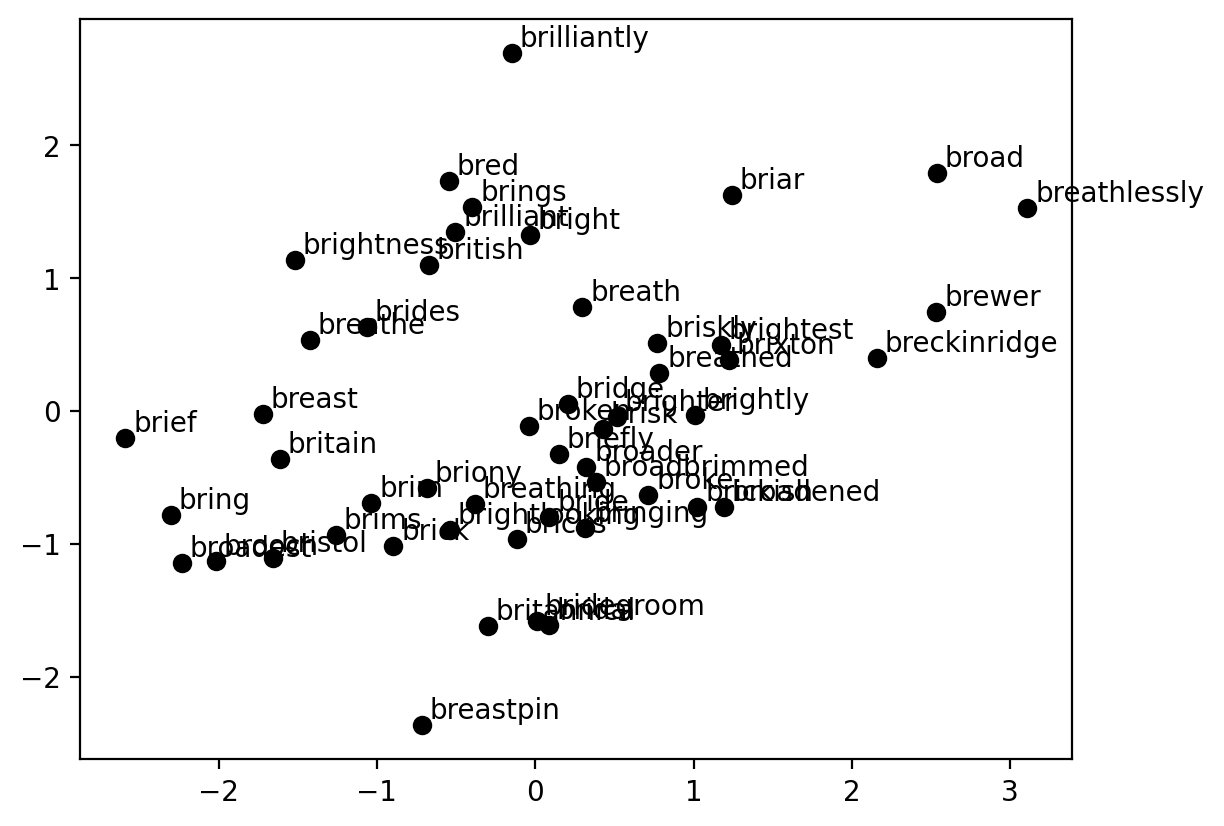

In [18]:
from sklearn.decomposition import PCA
def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    emb_weights = emb.weight.detach().cpu().numpy()
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb_weights)

    for i in range(50):
        x, y = emb_2d[i+1000]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i+1000])
    return ax

plot_emb(emb, itos)

In [19]:
# splitting the portion into training and testing purpose

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([98935, 5]),
 torch.Size([24734, 5]),
 torch.Size([98935]),
 torch.Size([24734]))

In [21]:
# Find the maximum string length
max_length = max(len(sentence) for sentence in paragraph_text)

print(f"The maximum string length is : {max_length}")

The maximum string length is : 75


In [22]:
class NextWord(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x


In [23]:
model = NextWord(block_size, len(stoi), emb_dim, 1024).to(device)
# model = torch.compile(model)


In [24]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([8684, 128])
lin1.weight torch.Size([1024, 640])
lin1.bias torch.Size([1024])
lin2.weight torch.Size([8684, 1024])
lin2.bias torch.Size([8684])


In [25]:
print(X_train.shape)
print(Y_train.shape)


torch.Size([98935, 5])
torch.Size([98935])


In [26]:
x = X_train[0:5]
y = Y_train[0:5]
print(X_train.shape)
print(x)
print(y)
print(x.shape)
print(y.shape)

torch.Size([98935, 5])
tensor([[   0,    0,    0,    0, 8333],
        [   0,    0,    0,  380,  374],
        [   0,    0,    0, 7173, 2993],
        [3728, 3989, 2693, 2388, 7654],
        [   0,    0,    0,    0,    0]], device='cuda:0')
tensor([7654, 2727,  560, 4495, 7654], device='cuda:0')
torch.Size([5, 5])
torch.Size([5])


In [ ]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4000
print_every = 50
elapsed_time = []
for epoch in range(501):
    start_time = time.time()
    for i in range(0, X_train.shape[0]-batch_size, batch_size):
        x = X_train[i:i+batch_size]
        y = Y_train[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
      print(epoch, loss.item())

0 6.441425323486328


In [ ]:
torch.save(model, 'model_embedding128_hidden_1024_relu_context5.pth')


In [ ]:
curr_model = torch.load('model_embedding128_hidden_1024_relu_context5.pth')
curr_model.eval()

In [ ]:
# Assuming you have a trained model
# Saving the model
torch.save(model.state_dict(), 'model2_embedding128_hidden_1024_relu_context5.pth')

# Loading the model
curr_model = NextWord(block_size, len(stoi), emb_dim, 32)  # Create an instance of the model
curr_model.load_state_dict(torch.load('model2_embedding128_hidden_1024_relu_context5'))
curr_model.eval()  # Set the model to evaluation mode
